In [1]:
%tensorflow_version 1.x
!pip install adversarial-robustness-toolbox
!git clone https://github.com/tensorflow/cleverhans.git
!pip install cleverhans/

TensorFlow 1.x selected.
     |████████████████████████████████| 491kB 37.0MB/s 
     |████████████████████████████████| 7.1MB 23.3MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
Cloning into 'cleverhans'...
remote: Enumerating objects: 13501, done.
remote: Total 13501 (delta 0), reused 0 (delta 0), pack-reused 13501
Receiving objects: 100% (13501/13501), 8.40 MiB | 13.66 MiB/s, done.
Resolving deltas: 100% (9494/9494), done.
Processing ./cleverhans
     |████████████████████████████████| 163kB 12.9MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=253453 sha256=bad9b5039d16683689e53ed14d1bde9d1e2aa1a8f6917a3c489538f8dd388932
  Stored in directory: /tmp/pip-ephem-wheel-cache-5rrrmt4u/wheels/d1/6b/1d/5cf7b3ca4c0cfc7f845628b8ed46366ab5f4f56b5483e9db7f
Successfully built cleverhans


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
import keras
import numpy as np
import matplotlib.pyplot as plt
from art.attacks import VirtualAdversarialMethod
from art.classifiers import KerasClassifier
from art.utils import load_dataset

import tensorflow as tf
import tensorflow_hub as hub
tf.compat.v1.disable_eager_execution()



# Step 1: Load the CIFAR-10 Dataset
(x_train, y_train), (x_test, y_test), min_, max_ = load_dataset(str("cifar10")) # Original Dataset
print("x_train shape: " + str(x_train.shape) + "\n" + "x_train size: " + str(x_train.size) + "\n" + # this print statement is used for understanding what the CIFAR-10 dataset is
      "y_train shape: " + str(y_train.shape) + "\n" + "y_train size: " + str(y_train.size) + "\n" +
      "x_test shape: " + str(x_test.shape) + "\n" + "x_test size: " + str(x_test.size) + "\n" +
      "y_test shape: " + str(y_test.shape) + "\n" + "y_test size: " + str(y_test.size) + "\n")
print()


# Step 2: Load the victim model
hub_url = "https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1"
embed = hub.KerasLayer(hub_url, input_shape=(32,32,3) )
model = tf.keras.Sequential([
    embed,
    tf.keras.layers.Activation( 'softmax' )
])
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()
classifier = KerasClassifier(model=model, clip_values=(0., 1.))

# Step 3: Evaluate the victim model on the benign dataset
predictions = classifier.predict(x_test) # giving the classifier the x_test of the CIFAR-10 dataset.
accuracy_benign = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test) # calculates the accuracy of the predictions
print("Accuracy on benign test examples: {}%\n".format(accuracy_benign * 100))

Using TensorFlow backend.


x_train shape: (50000, 32, 32, 3)
x_train size: 153600000
y_train shape: (50000, 10)
y_train size: 500000
x_test shape: (10000, 32, 32, 3)
x_test size: 30720000
y_test shape: (10000, 10)
y_test size: 100000


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 10)                7796426   
_________________________________________________________________
activation (Activation)      (None, 10)                0         
Total params: 7,796,426
Trainable params: 0
Non-trainable params: 7,796,426
_________________________________________________________________
Accuracy on benign test examples: 94.52000000000001%



In [3]:
# picking a test sample before generating adversarial examples
sample_pre = x_test_adv_pre[ 1, :]
print( sample_pre.shape )
plt.imshow( sample_pre )
plt.axis( 'off' )
plt.show( )
print("Label = " + str(np.argmax(y_test_adv[1])))
label_pre = np.argmax(classifier.predict( sample_pre.reshape( (1, sample_pre.shape[ 0 ], sample_pre.shape[ 1 ], sample_pre.shape[ 2 ]) ) ) )
print( 'class prediction for the test sample_pre:', label_pre )


NameError: ignored

x_test_adv_pre shape: (100, 32, 32, 3)
x_test_adv_pre size: 307200
y_test_adv_pre shape: (100, 10)
y_test_adv_pre size: 1000

(32, 32, 3)


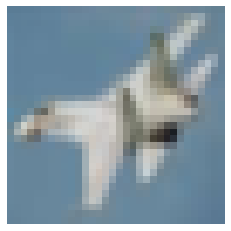

Label = 0
class prediction for the test sample_pre: 0


In [4]:
# Step 4: Collect 10 instances of each class from test set
def exract_ten_classes(data, labels, classes=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), no_instance=10):
    x_pre = []  # list to collect the x_test set
    y_pre = []  # list to collect the y_test set
    for class_label in range(0, 10):  # loop through each of the classes
        index = 0  # choose an index from the x_test
        iteration = no_instance  # number of instance of each class to collect
        while (iteration != 0):
            if np.argmax(labels[index]) == classes[class_label]:  # check if the current index label matches the specified class label we are looking for
                x_pre.append(data[index])  # add the image to the x_test set
                y_pre.append(int(class_label))  # add the image label to the y_test set
                iteration = iteration - 1  # reduce # of instances by 1
            index = index + 1  # go to next index till next label is of the current class
    x = np.asarray(x_pre)  # append all 100, 10 of each class, images together
    y = keras.utils.to_categorical(np.asarray(y_pre), 10)  # append all 100, 10 of each class, labels together and do one hot encoding
    return x, y

x_test_adv_pre, y_test_adv = exract_ten_classes( x_test, y_test ) # call the above function to extract 100 instances with 10 examples from each class
print("x_test_adv_pre shape: " + str(x_test_adv_pre.shape) + "\n" + "x_test_adv_pre size: " + str(x_test_adv_pre.size) + "\n" + # print statement just shows what the extracted set looks like
      "y_test_adv_pre shape: " + str(y_test_adv.shape) + "\n" + "y_test_adv_pre size: " + str(y_test_adv.size) + "\n")

# picking a test sample before generating adversarial examples
sample_pre = x_test_adv_pre[ 1, :]
print( sample_pre.shape )
plt.imshow( sample_pre )
plt.axis( 'off' )
plt.show( )
print("Label = " + str(np.argmax(y_test_adv[1])))
label_pre = np.argmax(model.predict( sample_pre.reshape( (1, sample_pre.shape[ 0 ], sample_pre.shape[ 1 ], sample_pre.shape[ 2 ]) ) ) )
print( 'class prediction for the test sample_pre:', label_pre )

In [0]:
from art.attacks import VirtualAdversarialMethod
# Step 5: Generate adversarial test examples
attack = VirtualAdversarialMethod(classifier=classifier, max_iter=10, finite_diff=1e-3, eps=0.5, batch_size=1) # Call the attack function and pass it the victim classifier, and for FGSM set the epsilon value
#print("Before")
#print(np.amax(x_test_adv_pre))
#print(np.amin(x_test_adv_pre))
#print(x_test_adv_pre[0])
#x_test_adv_pre = (x_test_adv_pre-np.amin(x_test_adv_pre))/(np.amax(x_test_adv_pre)-np.amin(x_test_adv_pre))

x_test_adv = attack.generate(x=x_test_adv_pre) # generate the adversarial examples from our extracted set. Creates 100 adversarial examples
#print("After")
#print(np.amax(x_test_adv_pre))
#print(np.amin(x_test_adv_pre))
#print(x_test_adv_pre[0])

In [0]:


# picking a test sample after generating adversarial examples
sample_post = x_test_adv( 1)
plt.imshow( sample_post )
plt.axis( 'off' )
plt.show( )
print("Label = " + str(np.argmax(y_test_adv[1])))
label_post = np.argmax(classifier.predict( sample_post.reshape( (1, sample_post.shape[ 0 ], sample_post.shape[ 1 ], sample_post.shape[ 2 ]) ) ) )
print( 'class prediction for the test sample_post:', label_post )



# Step 6: Evaluate the ART classifier on adversarial test examples
predictions = classifier.predict(x_test_adv) # predict how the classifier does on the adversarial examples
accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test_adv, axis=1)) / len(y_test_adv) # calculate the accruacy of the classifier on the adversarial examples
print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))